# News headline topic analysis with Latent Dirichlet allocation (LDA)
The purpose of this analysis is to find dominant topics across news headlines (25 per day, over 1 year). These topics will later be correlated with daily stock market loss/gain information to understand how certain topics influence the stock market.

## What is LDA?
Latent Dirichlet allocation is a way to discover higher-level topics out of individual words present in any set of document (in our case, news headlines). You can use LDA to get a sense of the overall themes in a set of documents. 

LDA is an unsupervised machine learning model that works by analyzing two things: a distribution of topics in a document, and a distribution of words in a topic. The "topics" it finds aren't specific words (e.g., "This headline is about 'war'") but instead conceptually similar groups of words that together make up a theme (e.g., "This headline is similar to the words 'war', 'crisis', 'iran'...").

Once you've created your LDA model, you can feed in a document and the model will score the overall relevancy of your document against the main _x_ topics found in your overall corpus. In other words, it will tell you which of the main topics found in the overall corpus are also found in your document, and to what extent.

## Why LDA?
LDA is a fairly popular topic modelling choice among NLP professionals, and relatively straightforward to implement. Using LDA, we were able to find 10 dominant themes in eight years' worth of news headlines within about an hour—a task that would take a human days to analyze.

## How does text pre-processing affect the accuracy of LDA?
We tested two pre-processing approaches: Bag of Words and TF-IDF, each of which count how often words appear in a document. The TF-IDF model tries to understand which words are more important than others in a document, and scores them accordingly. The assumption was that TF-IDF preprocessing will help train a more accurate LDA model, but that did not turn out to be true; Bag of Words performed better.

## How does LDA perform compared to other topic models?
LDA appears to perform more poorly than an NMF model on assigning topics to headline text, when topics are reviewed by humans. However, LDA topics perform _better_ in our regression analyses and neural network models, when used as features to predict stock market gains and losses.

## Credit
Parts of this work borrow from excellent Susan Li's ["Topic Modeling and LDA in Python"](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24) tutorial.

# Load the data from CSV, dependencies

In [1]:
# import dependencies
import pandas as pd

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import numpy as np
import random
np.random.seed(22)

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /Users/stacy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Import the headline-only data
data = pd.read_csv("../Data/RedditNews.csv")

In [3]:
data.head()

# Results in 73,608 records from 2016-2018

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [4]:
# Getting just the headlines for our corpus
headlines = data[['News']]
headlines.head()

,News
0,A 117-year-old woman in Mexico City finally re...
1,IMF chief backs Athens as permanent Olympic host
2,"The president of France says if Brexit won, so..."
3,British Man Who Must Give Police 24 Hours' Not...
4,100+ Nobel laureates urge Greenpeace to stop o...


# Data pre-processing
## Lemmitize
In order to properly identify topics, we need to standardize the words in some way, removing extraneous information like tenses or plurals (e.g. "running", "runs" -> "run"). Lemmatization is the best way to do that, although it's not always the fastest way. In some cases, stemming will also work, althought it is not as precise.

Since we have a relatively small corpus to study, we will use lemmatization in order to be as precise as possible when cleaning up the words. To do this, we will feed in a `pos` parameter that tells our lemmatizing function to perform stemming with context.

Natural Language Toolkit's `stem` package includes a handy function called `WordNetLemmatizer` that makes lemmatizing our words simple. 

In [5]:
# Lemmatize the words keeping the context (stemming is "dumb" so we won't)
# However if we have a much larger corpus, we might consider stemming (as it is faster)
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v') # pos='v' means it peforms stemming with context

## Remove stopwords and words shorter than 3 chars
We also need to remove common words that don't add value ("a", "the", etc). These are called _stopwords_, and most NLP libraries have built-in methods for dealing with them. In `gensim`, the stopwords list can be called using `gensim.parsing.preprocessing.STOPWORDS`.

In [6]:
# Remove stopwords and words shorter than 3 characters, then lemmatize
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result

## Check outputs
Let's compare the regular version of a sample headlind with the tokenized and lemmatized version. You'll note they are slightly different, but retain the same context.

In [7]:
sample = headlines['News'][2]

print('original document: ')
words = []
for word in sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(sample))

original document: 
['The', 'president', 'of', 'France', 'says', 'if', 'Brexit', 'won,', 'so', 'can', 'Donald', 'Trump']


 tokenized and lemmatized document: 
['president', 'france', 'say', 'brexit', 'donald', 'trump']


## Preprocess the headlines and save the results
Now we feed all the headlines into the preprocessing function, which lemmatizes and removes stopwords. 

In [8]:
cleaned_headlines = headlines['News'].map(preprocess)
print(cleaned_headlines[:5]) # Check the results
sample_size = cleaned_headlines.shape[0]

0    [year, woman, mexico, city, finally, receive, ...
1      [chief, back, athens, permanent, olympic, host]
2      [president, france, say, brexit, donald, trump]
3    [british, police, hours, notice, threaten, hun...
4    [nobel, laureates, urge, greenpeace, stop, opp...
Name: News, dtype: object


In [9]:
sample_size

73608

## Count the word occurences using Bag of Words
We can count the words using different approaches. Bag of Words will simply count all remaining words left in our corpus.

In [11]:
# First we need to convert the words to numeric indices. We can do that with a gensim Dictionary.

# corpora.Dictionary implements the concept of a Dictionary – a mapping between words and their integer ids.
# https://radimrehurek.com/gensim/corpora/dictionary.html

dictionary = gensim.corpora.Dictionary(cleaned_headlines)

In [12]:
'''
Filter out irrelevant words:
Keep tokens that appear in at least 15 documents
Keep only the 100,000 most frequent tokens
'''

dictionary.filter_extremes(no_below=15, keep_n=100000)

In [13]:
'''
Apply `doc2bow` to each headline, which createst a Bag of Words dictionary that reports how many words 
are in the headline and how many times each word appears.

Save this to an array, then check the example headline from above.
'''

bow_corpus = [dictionary.doc2bow(headline) for headline in cleaned_headlines]
print(bow_corpus[2])

bow_doc_2 = bow_corpus[2]

for i in range(len(bow_doc_2)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2[i][0], 
                                            dictionary[bow_doc_2[i][0]], 
                                            bow_doc_2[i][1]))

[(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]
Word 21 ("brexit") appears 1 time.
Word 22 ("donald") appears 1 time.
Word 23 ("france") appears 1 time.
Word 24 ("president") appears 1 time.
Word 25 ("say") appears 1 time.
Word 26 ("trump") appears 1 time.


## Count the word occurences using TF-IDF
We'll also test whether TF-IDF works better than Bag of Words for creating a corpus that, when fed into our LDA model, will produce coherent and accurate topics. 

In `gensim`, TF-IDF builds on Bag of Words, taking in processed BoW corpus data and returning a number that reflects how important a word is to each headline in the overall corpus. Conversely, the scikit-learn implementation of TF-IDF handles this all in one step.

In [14]:
from gensim import corpora, models

# Create the model
tfidf = models.TfidfModel(bow_corpus)

# Feed in the BoW corpus to the TF-IDF model
corpus_tfidf = tfidf[bow_corpus]

# Print the same headline from above
corpus_tfidf[2]

[(21, 0.5271930944921088),
 (22, 0.5289685708527566),
 (23, 0.3076906708092066),
 (24, 0.25211992539378436),
 (25, 0.18133987533447585),
 (26, 0.5011362450471095)]

## Running LDA using Bag of Words
We'll first run `LdaMulticore` using our `bow_corpus` and limiting our number of topics to 10. We're also going to print out the resulting topics and how the dominant words score in each topic. The parameter `id2word` helps us pass the numeric indices in our dictionary back into human-readable words.

In [15]:
# We'll first split the dataset into a random sample containing 90% of documents.

bow_sample = random.sample(bow_corpus, int(sample_size*.9))

# We have to play around with how many passes to take over the corpus in order to make the topics coherent
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2)

In [16]:
# Print each topic and how the words in those topics score (their relative weight)
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.029*"israel" + 0.022*"china" + 0.016*"iran" + 0.014*"state" + 0.013*"say" + 0.012*"attack" + 0.009*"world" + 0.009*"right" + 0.009*"human" + 0.008*"nuclear"
Topic: 1 
Words: 0.012*"bank" + 0.010*"government" + 0.009*"court" + 0.008*"million" + 0.007*"china" + 0.007*"police" + 0.007*"billion" + 0.007*"say" + 0.006*"chinese" + 0.006*"world"
Topic: 2 
Words: 0.031*"kill" + 0.018*"attack" + 0.014*"force" + 0.012*"bomb" + 0.010*"soldier" + 0.008*"army" + 0.008*"state" + 0.008*"syria" + 0.008*"taliban" + 0.008*"syrian"
Topic: 3 
Words: 0.023*"north" + 0.022*"korea" + 0.021*"kill" + 0.018*"south" + 0.013*"pakistan" + 0.010*"strike" + 0.009*"say" + 0.008*"people" + 0.008*"death" + 0.008*"year"
Topic: 4 
Words: 0.027*"israel" + 0.025*"gaza" + 0.013*"israeli" + 0.013*"palestinian" + 0.010*"ship" + 0.009*"hamas" + 0.008*"right" + 0.008*"west" + 0.008*"say" + 0.007*"report"
Topic: 5 
Words: 0.010*"world" + 0.010*"india" + 0.007*"water" + 0.007*"power" + 0.007*"years" + 0.007*"pl

## Running LDA using TF-IDF
We'll run the same LDA model on the corpus processed using TF-IDF, to see if the topics generated here are any more meaningful. We'll use the same other parameters in our `LdaMulticore` model, for consistency.

In [17]:
# Get random sample of tf_idf corpus
corpus_tfidf.corpus

tfidf_sample = random.sample(corpus_tfidf.corpus, int(sample_size*.9))

lda_model_tfidf = gensim.models.LdaMulticore(tfidf_sample, num_topics=10, id2word=dictionary, passes=2)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.026*"korea" + 0.026*"north" + 0.018*"nuclear" + 0.018*"russia" + 0.011*"say" + 0.010*"south" + 0.009*"world" + 0.009*"iran" + 0.008*"japan" + 0.008*"ukraine"
Topic: 1 Word: 0.015*"wikileaks" + 0.012*"israel" + 0.009*"say" + 0.007*"death" + 0.006*"release" + 0.006*"people" + 0.005*"assange" + 0.005*"government" + 0.005*"peace" + 0.005*"cable"
Topic: 2 Word: 0.029*"china" + 0.014*"world" + 0.009*"million" + 0.008*"years" + 0.008*"drug" + 0.008*"say" + 0.007*"water" + 0.007*"billion" + 0.006*"power" + 0.005*"chinese"
Topic: 3 Word: 0.031*"kill" + 0.016*"saudi" + 0.013*"women" + 0.009*"attack" + 0.009*"strike" + 0.008*"arabia" + 0.008*"soldier" + 0.007*"say" + 0.007*"pakistan" + 0.007*"gaza"
Topic: 4 Word: 0.014*"say" + 0.011*"government" + 0.010*"country" + 0.009*"call" + 0.007*"russian" + 0.006*"president" + 0.005*"state" + 0.005*"right" + 0.005*"asylum" + 0.005*"british"
Topic: 5 Word: 0.025*"israeli" + 0.021*"israel" + 0.013*"palestinian" + 0.011*"gaza" + 0.010*"say" +

## Compare the performance of the two preprocessing steps in the LDA model using Coherence Scores

In [18]:
# Get the baseline coherence scores for each model
# https://radimrehurek.com/gensim/models/coherencemodel.html
# Adapted from https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
from gensim.models import CoherenceModel
coherence_model_lda_bow = CoherenceModel(model=lda_model_bow, texts=cleaned_headlines, dictionary=dictionary, coherence='c_v')
coherence_lda_bow = coherence_model_lda_bow.get_coherence()
print('BOW Coherence Score: ', coherence_lda_bow)

BOW Coherence Score:  0.28573228769482645


In [19]:
coherence_model_lda_tfidf = CoherenceModel(model=lda_model_tfidf, texts=cleaned_headlines, dictionary=dictionary, coherence='c_v')
coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
print('TF-IDF Coherence Score: ', coherence_lda_tfidf)

TF-IDF Coherence Score:  0.2567845674912104


In [20]:
# our test headline from above
cleaned_headlines[2] # human-readable version of bow_corpus[2]

['president', 'france', 'say', 'brexit', 'donald', 'trump']

### Bag of Words LDA model scores

In [20]:
for index, score in sorted(lda_model_bow[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_bow.print_topic(index, 10)))


Score: 0.8713582158088684	 
Topic: 0.010*"say" + 0.008*"saudi" + 0.008*"election" + 0.008*"vote" + 0.008*"government" + 0.007*"party" + 0.007*"country" + 0.006*"leave" + 0.006*"drug" + 0.006*"european"

Score: 0.014297216199338436	 
Topic: 0.011*"government" + 0.009*"internet" + 0.008*"israeli" + 0.007*"say" + 0.007*"muslim" + 0.006*"president" + 0.006*"people" + 0.005*"protest" + 0.005*"right" + 0.005*"france"

Score: 0.0142947593703866	 
Topic: 0.022*"police" + 0.011*"russian" + 0.010*"president" + 0.009*"russia" + 0.008*"year" + 0.007*"woman" + 0.007*"shoot" + 0.007*"putin" + 0.007*"georgia" + 0.007*"protest"

Score: 0.014294148422777653	 
Topic: 0.024*"iran" + 0.016*"russia" + 0.014*"world" + 0.013*"nuclear" + 0.011*"iraq" + 0.008*"china" + 0.007*"say" + 0.006*"obama" + 0.006*"missile" + 0.005*"troop"

Score: 0.014293360523879528	 
Topic: 0.030*"kill" + 0.018*"attack" + 0.014*"force" + 0.012*"bomb" + 0.009*"soldier" + 0.009*"army" + 0.008*"syria" + 0.008*"state" + 0.008*"rebel" + 

### TF-IDF LDA model scores

In [21]:
for index, score in sorted(lda_model_tfidf[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index)))


Score: 0.6193434000015259	 
Topic: 0.019*"right" + 0.015*"human" + 0.012*"vote" + 0.012*"court" + 0.010*"rule" + 0.010*"party" + 0.009*"minister" + 0.009*"say" + 0.007*"prime" + 0.006*"government"

Score: 0.26631179451942444	 
Topic: 0.029*"korea" + 0.028*"north" + 0.017*"south" + 0.016*"russia" + 0.015*"nuclear" + 0.013*"iran" + 0.011*"say" + 0.009*"russian" + 0.009*"korean" + 0.007*"weapons"

Score: 0.014295932836830616	 
Topic: 0.023*"israeli" + 0.010*"palestinian" + 0.009*"kill" + 0.008*"gaza" + 0.008*"say" + 0.007*"years" + 0.007*"egypt" + 0.006*"shoot" + 0.006*"year" + 0.006*"bank"

Score: 0.014295103028416634	 
Topic: 0.019*"police" + 0.013*"say" + 0.012*"putin" + 0.011*"russia" + 0.010*"president" + 0.009*"state" + 0.009*"anti" + 0.009*"protest" + 0.007*"russian" + 0.007*"attack"

Score: 0.014293752610683441	 
Topic: 0.031*"israel" + 0.011*"gaza" + 0.010*"state" + 0.010*"syrian" + 0.009*"isis" + 0.009*"israeli" + 0.008*"attack" + 0.008*"force" + 0.008*"iraq" + 0.007*"rebel"

S

Both approaches have relatively high accuracy with classification (> .80), and mostly make sense when reviewed by a human. What if we predicted topics for a headline that does not appear in our training set?

### Testing models on a new headline
When using an unseen headline, the Bag of Words-trained LDA model appears to classify the headline's topic more accurately.

* Bag of Words top topic: `Topic: 0.023*"iran" + 0.015*"russia" + 0.015*"iraq" + 0.014*"world" + 0.012*"nuclear"`
* TF-IDF top topic: `Topic: 0.012*"say" + 0.011*"government" + 0.007*"call" + 0.007*"pope" + 0.006*"party"`

In [22]:
unseen_document = 'Trump finally broke with Fauci'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("BoW approach\n")
for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_bow.print_topic(index, 5)))
    
print("\nTF-IDF approach")
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

BoW approach

Score: 0.49163854122161865	 Topic: 0.024*"iran" + 0.016*"russia" + 0.014*"world" + 0.013*"nuclear" + 0.011*"iraq"
Score: 0.3082481920719147	 Topic: 0.010*"say" + 0.008*"saudi" + 0.008*"election" + 0.008*"vote" + 0.008*"government"
Score: 0.025018639862537384	 Topic: 0.012*"bank" + 0.010*"government" + 0.009*"court" + 0.008*"million" + 0.007*"police"
Score: 0.02501649782061577	 Topic: 0.011*"government" + 0.009*"internet" + 0.008*"israeli" + 0.007*"say" + 0.007*"muslim"
Score: 0.02501625195145607	 Topic: 0.022*"police" + 0.011*"russian" + 0.010*"president" + 0.009*"russia" + 0.008*"year"
Score: 0.025013970211148262	 Topic: 0.026*"israel" + 0.025*"china" + 0.015*"iran" + 0.013*"state" + 0.013*"say"
Score: 0.02501264028251171	 Topic: 0.031*"israel" + 0.026*"gaza" + 0.014*"israeli" + 0.014*"palestinian" + 0.010*"ship"
Score: 0.02501220814883709	 Topic: 0.023*"north" + 0.022*"korea" + 0.021*"kill" + 0.018*"south" + 0.013*"pakistan"
Score: 0.025011790916323662	 Topic: 0.030*"ki

## Export the model
We'll use the LDA-Bag of words model, which appears to be more accurate (based on our test documents).

In [23]:
import joblib
joblib.dump(lda_model_bow, "lda_bow.gz")

['lda_bow.gz']

## Append topics and scores to cleaned dataset

In [24]:
# This function returns the best-scoring topic and score assocated with a headline
def topic_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return topic

topic_getter(unseen_document)

7

In [25]:
# Load dataset with combined data
all_data = pd.read_csv('../Data/Combined_News_DJIA.csv')
all_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [26]:
all_data.dropna(how='any', inplace=True)

In [27]:
# Loop through the columns containing headlines and apply `topic_getter` to each headline, to retrieve topic
# Assign that data to a new column

for x in range(1,26): # for each column
    col = "Top" + str(x)
    new_col = col + "_topic"
    
    # for each row in column
    # get the headline, feed it into the lda_model_bow to get the topic and score
    all_data[new_col] = all_data[col].apply(topic_getter)

In [28]:
# Check the output
all_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16_topic,Top17_topic,Top18_topic,Top19_topic,Top20_topic,Top21_topic,Top22_topic,Top23_topic,Top24_topic,Top25_topic
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,6,2,0,7,2,7,6,2,7,6
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,0,6,6,0,3,4,6,6,7,5
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,6,6,0,6,1,2,6,9,9,5
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,3,4,2,4,0,5,7,4,4,6
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,0,0,4,4,6,9,2,4,2,2


In [29]:
# Save updated data
all_data.to_csv("../Data/Combined_News_DJIA_topics.csv")

# Find one dominant topic per day

In [30]:
single_topic = all_data
del all_data # Removing now that unneeded to improve performance

In [31]:
# Drop unnecessary columns from prev dataframe
cols = []
for x in range(1,26):
    cols.append("Top" + str(x) + "_topic")  

single_topic.drop(axis=1, labels=cols, inplace=True)
single_topic.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [32]:
# Combine, clean single_topic headlines 
single_topic.loc[:,'combined_headlines'] = single_topic.loc[:,'Top1'] + " " + single_topic.loc[:,'Top2'] \
                                        + " " + single_topic.loc[:,'Top3'] + " " + single_topic.loc[:,'Top4'] \
                                        + " " + single_topic.loc[:,'Top5'] + " " + single_topic.loc[:,'Top6'] \
                                        + " " + single_topic.loc[:,'Top7'] + " " + single_topic.loc[:,'Top8'] \
                                        + " " + single_topic.loc[:,'Top9'] + " " + single_topic.loc[:,'Top10'] \
                                        + " " + single_topic.loc[:,'Top11'] + " " + single_topic.loc[:,'Top12'] \
                                        + " " + single_topic.loc[:,'Top13'] + " " + single_topic.loc[:,'Top14'] \
                                        + " " + single_topic.loc[:,'Top15'] + " " + single_topic.loc[:,'Top16'] \
                                        + " " + single_topic.loc[:,'Top17'] + " " + single_topic.loc[:,'Top18'] \
                                        + " " + single_topic.loc[:,'Top19'] + " " + single_topic.loc[:,'Top20'] \
                                        + " " + single_topic.loc[:,'Top21'] + " " + single_topic.loc[:,'Top22'] \
                                        + " " + single_topic.loc[:,'Top23'] + " " + single_topic.loc[:,'Top24'] \
                                        + " " + single_topic.loc[:,'Top25']

single_topic.loc[:,'combined_headlines'] = single_topic.loc[:,'combined_headlines'].str.replace('b[\'\"]', ' ')
single_topic.dropna(how='any', inplace=True)

cleaned_all_headlines = single_topic['combined_headlines'].map(preprocess)

single_topic.iloc[905,:]

Date                                                         2012-03-16
Label                                                                 0
Top1                  Chinese official proposes death penalty as det...
Top2                  New Chevron Oil Leak Off Coast of Brazil - Jus...
Top3                    Shell admits to at least 207 oil spills in 2011
Top4                  A Jewish man wins his fight against a German m...
Top5                  UK would not help Israel attack Iran, Prime Mi...
Top6                  "Afghan President Hamid Karzai lashed out at t...
Top7                  Putin's Fabled Tiger Encounter was PR Stunt, S...
Top8                  Moroccans call for end to rape-marriage laws -...
Top9                  Friends no more? Egypts MPs declare Israel No....
Top10                 In emails, the nuclear physicist at one of Eur...
Top11                 Syrian armed forces desertion said to surge to...
Top12                 A Moroccan government minister on Thursday

In [33]:
# Count word occurences using Bag of Words on new cleaned_headlines
dictionary = gensim.corpora.Dictionary(cleaned_all_headlines)

In [34]:
'''
Filter out irrelevant words:
Keep tokens that appear in at least 15 documents
Keep only the 100,000 most frequent tokens
'''

dictionary.filter_extremes(no_below=15, keep_n=100000)

In [35]:
'''
Apply `doc2bow` to each headline, which createst a Bag of Words dictionary that reports how many words 
are in the headline and how many times each word appears.

Save this to an array, then check the example headline from above.
'''


bow_corpus = [dictionary.doc2bow(headline) for headline in cleaned_all_headlines]
print(bow_corpus[2])

bow_doc_2 = bow_corpus[2]

for i in range(len(bow_doc_2)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2[i][0], 
                                            dictionary[bow_doc_2[i][0]], 
                                            bow_doc_2[i][1]))

[(12, 1), (13, 1), (15, 1), (21, 1), (30, 1), (33, 10), (34, 4), (42, 1), (44, 1), (45, 1), (47, 1), (58, 1), (59, 3), (62, 2), (63, 1), (65, 1), (66, 1), (67, 2), (68, 3), (78, 1), (83, 5), (84, 2), (94, 4), (95, 1), (103, 2), (106, 1), (111, 1), (121, 1), (125, 1), (136, 1), (139, 2), (199, 1), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 1), (208, 1), (209, 1), (210, 1), (211, 1), (212, 1), (213, 1), (214, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 1), (221, 1), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 2), (230, 2), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 1), (238, 1), (239, 2), (240, 1), (241, 1), (242, 1), (243, 1), (244, 1), (245, 1), (246, 1), (247, 1), (248, 1), (249, 1), (250, 1), (251, 1), (252, 1), (253, 1), (254, 1), (255, 2), (256, 1), (257, 2), (258, 1), (259, 1), (260, 1), (261, 1), (262, 1), (263, 1), (264, 1), (265, 1), (266, 1), (267, 1), (268, 1), (269, 1), (2

In [36]:
# Run new BoW data through LDA model

'''
NOTE: Run this on a machine with lots of processing power, or as a Google Colab notebook. Otherwise it might
take a really long time to run! TODO: Refactor this notebook to optimize performance so it can be run locally.
'''

bow_sample = random.sample(bow_corpus, int(cleaned_all_headlines.shape[0]*.9))

lda_model_bow = gensim.models.LdaMulticore(bow_sample, num_topics=10, id2word=dictionary, passes=2)

In [37]:
# Get coherence score for new single-topic model
coherence_model_lda_bow = CoherenceModel(model=lda_model_bow, texts=cleaned_headlines, dictionary=dictionary, coherence='c_v')
coherence_lda_bow = coherence_model_lda_bow.get_coherence()
print('BOW one topic per day Coherence Score: ', coherence_lda_bow)

BOW one topic per day Coherence Score:  0.1656104943856004


Note: The "one topic per day" LDA model performs more poorly than the "one topic per headline" BOW model (above).

In [38]:
# Print each topic and how the words in those topics score (their relative weight)
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"protest" + 0.003*"syria" + 0.003*"isis" + 0.003*"north" + 0.003*"plan" + 0.003*"country" + 0.003*"minister"
Topic: 1 
Words: 0.006*"russian" + 0.005*"russia" + 0.004*"president" + 0.004*"million" + 0.004*"force" + 0.003*"military" + 0.003*"syria" + 0.003*"protest" + 0.003*"group" + 0.003*"plan"
Topic: 2 
Words: 0.006*"russia" + 0.004*"japan" + 0.003*"president" + 0.003*"korea" + 0.003*"power" + 0.003*"country" + 0.003*"time" + 0.003*"force" + 0.003*"call" + 0.003*"protest"
Topic: 3 
Words: 0.005*"russia" + 0.004*"iran" + 0.004*"north" + 0.004*"force" + 0.004*"military" + 0.004*"right" + 0.004*"korea" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"
Topic: 4 
Words: 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.004*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"
Topic: 5 
Words: 0.005*"force" + 0.005*"russia" + 0.005*"russian" + 0.004*"in

In [39]:
# Test new model on unseen dataset
unseen_document = 'Trump finally broke with Fauci'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("BoW approach\n")
for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_bow.print_topic(index, 10)))
    
# This has a higher accuracy score than the per-headline topic analysis above

BoW approach

Score: 0.7748358249664307	 Topic: 0.008*"israeli" + 0.008*"gaza" + 0.005*"right" + 0.005*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"arrest" + 0.004*"country" + 0.003*"president" + 0.003*"force"
Score: 0.02502274140715599	 Topic: 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"protest" + 0.003*"syria" + 0.003*"isis" + 0.003*"north" + 0.003*"plan" + 0.003*"country" + 0.003*"minister"
Score: 0.025019222870469093	 Topic: 0.005*"russia" + 0.004*"bank" + 0.004*"president" + 0.004*"force" + 0.004*"plan" + 0.004*"time" + 0.004*"death" + 0.003*"military" + 0.003*"right" + 0.003*"korea"
Score: 0.025018690153956413	 Topic: 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.004*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"
Score: 0.02501818537712097	 Topic: 0.005*"russia" + 0.004*"iran" + 0.004*"north" + 0.004*"force" + 0.004*"military" + 0.004*"right" + 0.004*"korea" + 0.004*"south" + 0.003*"ukraine" 

In [40]:
# This function returns the best-scoring topic and score assocated with a headline
def topic_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return topic
    
def word_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return lda_model_bow.print_topic(topic, 10)    

# Test to confirm it still returns the topic for a particular headline
topic_getter(unseen_document)
word_getter(unseen_document)

'0.008*"israeli" + 0.008*"gaza" + 0.005*"right" + 0.005*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"arrest" + 0.004*"country" + 0.003*"president" + 0.003*"force"'

In [41]:
# Create a combined function to test our testing dataset against    

population = 1986

def test_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        # Print a headline snippet and the topic so we can visually compare each headline set against the assigned topic
        print(f"headline: {headline[0:300]}\n\n topic: {str(topic)} {lda_model_bow.print_topic(topic, 10)}\n\n")    

# Create a random sample of 20% of our overall document set        
sample_series = random.sample(list(single_topic['combined_headlines']), int(population*.2))

for headline in sample_series:
    test_getter(headline)

headline: Archaeologists find sealed tunnel underneath Teotihuacan temple 13-year-old Syrian boy arrested, brutally tortured, beaten, burned, slashed, penis cut off, murdered Egypt: general confirms "virginity checks" forced on female protesters by military   Australia Suspends Live Cattle Exports to Indonesi

 topic: 1 0.006*"russian" + 0.005*"russia" + 0.004*"president" + 0.004*"million" + 0.004*"force" + 0.003*"military" + 0.003*"syria" + 0.003*"protest" + 0.003*"group" + 0.003*"plan"


headline: Italy changes law to make all supermarkets give unsold food to needy Putin orders most troops out of Syria Google's AlphaGo AI beats Lee Se-dol again to win Go series 4-1 Israeli hiker finds 2,000-year-old gold coin  the second of its kind to ever be found: The coin, from the year A.D. 107, bears th

 topic: 6 0.005*"iran" + 0.005*"israeli" + 0.004*"minister" + 0.004*"russia" + 0.004*"gaza" + 0.004*"nuclear" + 0.004*"right" + 0.003*"want" + 0.003*"call" + 0.003*"court"


headline:  Two elde

headline: Police officer will be charged with manslaughter over the death of Ian Tomlinson at the G20 protests NSFW A tank shoots brave Syrian protesters, killing a child. 20th May Mubarak to be tried for death of protestors A police officer will face trial for manslaughter over the death of newspaper seller 

 topic: 8 0.007*"north" + 0.006*"korea" + 0.004*"right" + 0.004*"death" + 0.004*"court" + 0.003*"nuclear" + 0.003*"iran" + 0.003*"south" + 0.003*"time" + 0.003*"germany"


headline:  Canada: Wal-Mart tries to prevent employee unionization. Wal-Mart tries to go to Supreme Court. Wal-Mart loses.'  After suffering a financial meltdown, 60-70% of Iceland's fishing stock is infected by a parasite, making it nearly impossible to sell. Fishing accounts for half of Iceland's exports." 

 topic: 7 0.008*"israeli" + 0.008*"gaza" + 0.005*"right" + 0.005*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"arrest" + 0.004*"country" + 0.003*"president" + 0.003*"force"


headline: Volkswagen has admi

headline: Ontario is putting an end to coal-burning power plants: '...on the verge of becoming the first industrial region in North America to eliminate all coal-fired electrical generation.' In sign of growing Chinese frustration with North Korea, Daily Show clip mocking Kim Jong Un gets 2.8 million views on

 topic: 8 0.007*"north" + 0.006*"korea" + 0.004*"right" + 0.004*"death" + 0.004*"court" + 0.003*"nuclear" + 0.003*"iran" + 0.003*"south" + 0.003*"time" + 0.003*"germany"


headline: Nuclear fusion device's 1st test with hydrogen declared a success UN panel 'rules in Assange's favour' World is about to eradicate the first human disease since smallpox - the gruesome Guinea worm Woman assaulted by cop who lost his job found dead in Holloway prison cell A 10-year-old Afghan boy who

 topic: 9 0.005*"russia" + 0.004*"bank" + 0.004*"president" + 0.004*"force" + 0.004*"plan" + 0.004*"time" + 0.004*"death" + 0.003*"military" + 0.003*"right" + 0.003*"korea"


headline: Man beheaded and Is

headline: More prisoners at Guantanamo Bay have joined a growing hunger strike that their lawyers say reflects hopelessness about their prospects of ever being freed from the detention center in Cuba. british water companies are caught avoiding tax, while raising consumer bills and paying millions to their bo

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"protest" + 0.003*"syria" + 0.003*"isis" + 0.003*"north" + 0.003*"plan" + 0.003*"country" + 0.003*"minister"


headline:  The Other Man On The Podium'  Dutch non-profit reproductive health organization sails ship around the world, anchoring in international waters to provide abortions to women in countries where abortion is banned'  Grand Ayatollah Issues Decree Calling Muslims to Defend Iraq's Christians"  Marx Das K

 topic: 9 0.005*"russia" + 0.004*"bank" + 0.004*"president" + 0.004*"force" + 0.004*"plan" + 0.004*"time" + 0.004*"death" + 0.003*"military" + 0.003*"right" + 0.003*"korea"


headline: Italian Wikip

headline: Bangladeshi garment workers, lowest paid in the world at $0.21/hour, torch 10-story factory at Gazipur + 15 full garment trucks. No human casualties, $100 million losses to the owners. Without Anyone Paying Attention, Canada Is About To Change Its Laws To Support ACTA - "They can point to the tiny, 

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.004*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: New Alzheimers treatment fully restores memory function - Australian researchers have come up with a non-invasive ultrasound technology that clears the brain of neurotoxic amyloid plaques The Pirate Party is now measured as the biggest political party in Iceland US removes Iran and Hezbollah from li

 topic: 3 0.005*"russia" + 0.004*"iran" + 0.004*"north" + 0.004*"force" + 0.004*"military" + 0.004*"right" + 0.004*"korea" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline: Mexico

headline: Thousands in Moscow chant Russia without Putin Charlie Hebdo now has 25 times as many subscribers as before deadly attack PayPal stops accepting payments for Kim Dotcom ' s Mega service because it uses encryption Russian chessmaster Kasparov: Now there's 'no chance' for a peaceful transition beyond 

 topic: 3 0.005*"russia" + 0.004*"iran" + 0.004*"north" + 0.004*"force" + 0.004*"military" + 0.004*"right" + 0.004*"korea" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline:  Top Imams affiliated with the Islamic Supreme Council of Canada have issued a fatwa calling those terrorists who attack the United States and Canada evil.'  Human sacrifices increase in Uganda; blood and body parts used in spell-casting to gain wealth'  An Indian man is in a serious condition in ho

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.004*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Hadron

headline: Afghan insurgents give captive reporter a cell phone to show them the Internet, so he tweets his whereabouts.  Terrorism : Suicide attack in Russia kills 15, wounds over 100 Olympic Disaster in Vancouver, Taxpayers on Hook for $1 Billion "Ghost Town" Anti-Israel boycotts are gaining speed What Ameri

 topic: 1 0.006*"russian" + 0.005*"russia" + 0.004*"president" + 0.004*"million" + 0.004*"force" + 0.003*"military" + 0.003*"syria" + 0.003*"protest" + 0.003*"group" + 0.003*"plan"


headline:  "But a remarkable thing happened this week. On Monday, 400 of his fellow students, wearing black in solidarity and carrying signs of support, walked out of Keswick High School to rally in protest in front of their school."'  Remember that Policeman driving at 90mph in a 30 zone with no sirens who h

 topic: 3 0.005*"russia" + 0.004*"iran" + 0.004*"north" + 0.004*"force" + 0.004*"military" + 0.004*"right" + 0.004*"korea" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline:  ...an

headline: Twelve North Korean soldiers attempting to defect have been captured by Chinese troops and sent back to NK India passes rape law that sets age of consent at 18 North Korea says, "North Korea is a great place for human rights." South Korea admits that the Hacking Attempt from an IP address from China

 topic: 8 0.007*"north" + 0.006*"korea" + 0.004*"right" + 0.004*"death" + 0.004*"court" + 0.003*"nuclear" + 0.003*"iran" + 0.003*"south" + 0.003*"time" + 0.003*"germany"


headline: BBC staff ordered to stop giving equal air time to climate deniers: The network will stop airing "debates" featuring members of the anti-science fringe 63 abducted women, girls escape from Boko Haram Dalai Lama urges halt to Buddhist violence against Muslims Poverty-stricken Filipino parents are inc

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.004*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Julian Assa

headline:  $US 13 billion of the money allocated for reconstruction projects in Iraq was wasted or stolen, with some of it ending up in al-Qaedas coffers'  [Breaking] 'Shooting' at school in Finland"  Noida CEO beaten to death by sacked employees'  Japan starts work on $9B 'space elevator' to replace rockets 

 topic: 6 0.005*"iran" + 0.005*"israeli" + 0.004*"minister" + 0.004*"russia" + 0.004*"gaza" + 0.004*"nuclear" + 0.004*"right" + 0.003*"want" + 0.003*"call" + 0.003*"court"


headline: Britain will vote on whether to remain in the EU on the 23rd of June Venezuelans face a 6000% hike in gasoline price from $0.01 to $0.60 ISIS Terrorist Cell Dismantled in Morocco 'Planned to Use Biological Weapons' Warming waters in the Atlantic and Pacific oceans have increased the prevalence of di

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"protest" + 0.003*"syria" + 0.003*"isis" + 0.003*"north" + 0.003*"plan" + 0.003*"country" + 0.003*"minister"


headline: New Zealand Pr

headline: France wants to fight terrorism by spying on everyone - Prime minister says proposed surveillance law 'is not a French Patriot Act,' but civil liberties groups say it goes too far Italian police: Migrants threw Christians overboard | Muslims who were among migrants trying to get from Libya to Italy 

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.004*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: "There's a wide discrepancy, and we need to know." Canadian military: The loss of four Canadian soldiers in September 2006 was the result of insurgent activity. Newly released WikiLeaks document: The Canadian soldiers weren't killed by the Taliban but rather by friendly fire from U.S. forces. Britis

 topic: 8 0.007*"north" + 0.006*"korea" + 0.004*"right" + 0.004*"death" + 0.004*"court" + 0.003*"nuclear" + 0.003*"iran" + 0.003*"south" + 0.003*"time" + 0.003*"germany"


headline:  Israeli fa

headline: Chinese companies will be able to sue Canada in secret for trying to protect the Canadian environment if FIPPA (Canada-China Foreign Investment Promotion and Protection Act) passes! Afghan girl 'beheaded for refusing prostitution'. Afghan police have arrested four people who allegedly tried to force

 topic: 2 0.006*"russia" + 0.004*"japan" + 0.003*"president" + 0.003*"korea" + 0.003*"power" + 0.003*"country" + 0.003*"time" + 0.003*"force" + 0.003*"call" + 0.003*"protest"


headline: Lone man stands up to rioters in Vancouver. "This is our city. What the fuck are you doing?" (crossposted from r/canada) Today, Saudi women defy driving ban and take the driver's seat en masse! South Korea rejects North's demands for return of defectors Fukushima: It's much worse than you think Dist

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"protest" + 0.003*"syria" + 0.003*"isis" + 0.003*"north" + 0.003*"plan" + 0.003*"country" + 0.003*"minister"


headline:  UN headqua

headline: Power grids fail, leaving 600 million without power in India  A Stradivarius violin  possibly worth several million pounds  has been handed in at a Swiss lost-property office after a hapless musician left it on a train.  Auschwitz era ends:  A spokesperson for Auschwitz museum says the last survivin

 topic: 3 0.005*"russia" + 0.004*"iran" + 0.004*"north" + 0.004*"force" + 0.004*"military" + 0.004*"right" + 0.004*"korea" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline: Faced with a cash shortage in its so-called caliphate, the Islamic State group has slashed salaries across the region, asked Raqqa residents to pay utility bills in black market American dollars, and is now releasing detainees for a price of $500 a person. According to NASA data this January was the

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"protest" + 0.003*"syria" + 0.003*"isis" + 0.003*"north" + 0.003*"plan" + 0.003*"country" + 0.003*"minister"


headline: Saudi Arabi

headline: Indian Govt uses special powers to slash cancer drug price by 97% Dangerous Ignorance: The Hysteria of Kony 2012 British stroke victim wins right to ask for euthanasia. China cracks down on human trafficking, freeing 24,000 abducted women and children in 2011 The alleged rape of a 16-year-old Muslim

 topic: 8 0.007*"north" + 0.006*"korea" + 0.004*"right" + 0.004*"death" + 0.004*"court" + 0.003*"nuclear" + 0.003*"iran" + 0.003*"south" + 0.003*"time" + 0.003*"germany"


headline:  US troops and contractors caused substantial damage to the archeological site at Babylon, a city considered as one of the first civilizations on earth.'  Kill IE6, for the sake of the web: expert'  Rafsanjani - "Don\'t let our enemies laugh at us by putting people in prison"'  The World Health Orga

 topic: 3 0.005*"russia" + 0.004*"iran" + 0.004*"north" + 0.004*"force" + 0.004*"military" + 0.004*"right" + 0.004*"korea" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline:  Professional sni

This seems to work all right, but we should eventually explore options for understanding the "coherence" of each topic (here's an example of what coherence looks like with [an NMF model](https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb)). The topics aren't perfect, thus we may want to find a more optimal number of topics to split our texts into.

Given the small population of combined headline texts (~1900), we should also eventually explore [k-fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/), which is often better than setting train-test splits for smaller populations.

## Improving the LDA model - hyperparameter tuning
### Determining K best topics

In [48]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# Adapting content from 'Hyperparameter tuning' section

In [42]:
single_topic['daily_topic'] = single_topic['combined_headlines'].apply(topic_getter)
single_topic['daily_words'] = single_topic['combined_headlines'].apply(word_getter)

In [43]:
single_topic.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top19,Top20,Top21,Top22,Top23,Top24,Top25,combined_headlines,daily_topic,daily_words
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",Georgia 'downs two Russian warplanes' as coun...,1,"0.006*""russian"" + 0.005*""russia"" + 0.004*""pres..."
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",Why wont America and Nato help us? If they wo...,1,"0.006*""russian"" + 0.005*""russia"" + 0.004*""pres..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,"b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",Remember that adorable 9-year-old who sang at...,1,"0.006*""russian"" + 0.005*""russia"" + 0.004*""pres..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,"b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,U.S. refuses Israel weapons to attack Iran: ...,1,"0.006*""russian"" + 0.005*""russia"" + 0.004*""pres..."
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,"b'""Non-media"" photos

In [44]:
# Save updated data
single_topic.to_csv("../Data/Combined_News_DJIA_single_topic.csv", index=False)

Text(0.5, 1.0, 'Topic distribution')

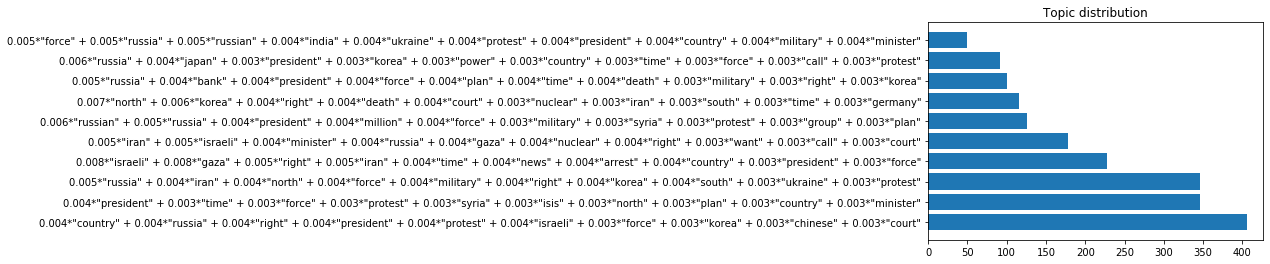

In [45]:
# What is the topic distribution?

names = single_topic['daily_words'].value_counts().index
values = single_topic['daily_words'].value_counts().values
plt.barh(names, values)
plt.yticks(names)
plt.title("Topic distribution")

In [46]:
# Export our improved LDA model
import joblib
joblib.dump(lda_model_bow, "lda_bow_improved.gz")

['lda_bow_improved.gz']